In [ ]:
CloseKernels[];
Kernels[]

{}

In [ ]:
(* EmpiricalH[\[Alpha]_, \[Sigma]w_, \[Sigma]b_, \[Phi]_, width_, depth_
    ] :=
    Module[{h = RandomReal[{-1, 1}, width]},
        Do[
            With[{M = \[Sigma]w width ^ (-1 / \[Alpha]) RandomVariate[
                StableDist[\[Alpha]], {width, width}], b = \[Sigma]b RandomVariate[StableDist[
                \[Alpha]], width]},
                h = M . \[Phi][h] + b
            ]
            ,
            depth
        ];
        h
    ] *)

In [ ]:
With[{\[Alpha] = 2, \[Sigma]w = 1, \[Sigma]b = 0.1, \[Phi] = Tanh, width
     = 100, depth = 100},
    Module[{h = RandomReal[{-1, 1}, width], M, b},
        Do[
            M = RandomVariate[StableDistribution[\[Alpha], 0, 0, \[Sigma]w
                 (2 width) ^ (-1 / \[Alpha])], {width, width}];
            b = RandomVariate[StableDistribution[\[Alpha], 0, 0, \[Sigma]b
                 2 ^ (-1 / \[Alpha])], width];
            h = M . \[Phi][h] + b
            ,
            depth
        ];
        (StandardDeviation[#]/Abs@Mean[#]&)@Log@SingularValueList[DiagonalMatrix[\[Phi]'[h]] . M]
    ]
]


2.00318

In [10]:
CVLogSingValsMLP[\[Alpha]_, \[Sigma]w_, \[Sigma]b_, \[Phi]_, width_, depth_
    ] :=
    Module[{h = RandomReal[{-1, 1}, width], M, b},
        Do[
            M = RandomVariate[StableDistribution[\[Alpha], 0, 0, \[Sigma]w
                 (2 width) ^ (-1 / \[Alpha])], {width, width}];
            b = If[\[Sigma]b > 0, RandomVariate[StableDistribution[\[Alpha], 0, 0, \[Sigma]b
                 2 ^ (-1 / \[Alpha])], width], ConstantArray[0, width]];
            h = M . \[Phi][h] + b
            ,
            depth
        ];
        (StandardDeviation[#]/Abs@Mean[#]&)@Log@SingularValueList[DiagonalMatrix[\[Phi]'[h]] . M]
    ]

In [ ]:
CVLogSingValsMLPSeeded[\[Alpha]_, \[Sigma]w_, \[Sigma]b_, \[Phi]_, width_, depth_, seed_
    ] :=
    BlockRandom[
    Module[{h = RandomReal[{-1, 1}, width], M, b},
        Do[
            M = \[Sigma]w RandomVariate[StableDistribution[\[Alpha], 0, 0, 
                 (2 width) ^ (-1 / \[Alpha])], {width, width}];
            b = If[\[Sigma]b > 0, \[Sigma]b RandomVariate[StableDistribution[\[Alpha], 0, 0, 
                 2 ^ (-1 / \[Alpha])], width], ConstantArray[0, width]];
            h = M . \[Phi][h] + b
            ,
            depth
        ];
        (StandardDeviation[#]/Abs@Mean[#]&)@Log@SingularValueList[DiagonalMatrix[\[Phi]'[h]] . M]
    ],
    RandomSeeding -> seed]


In [ ]:
CVLogSingValsMLP[2, 1, 0, Tanh, 2, 2]

1.054

In [11]:
DistributeDefinitions[CVLogSingValsMLP]

{CVLogSingValsMLP}

In [ ]:
Map[Mean, {{{1, 1.1}, {2, 2.1}}, {{3, 3.1}, {4, 4.1}}}, {2}]

{{1.05, 2.05}, {3.05, 4.05}}

In [ ]:
(cvList = (Map[Mean, #, {2}]&)@ParallelOuter[
{\[Alpha],\[Sigma]w, i} |-> 
    CVLogSingValsMLP[\[Alpha], \[Sigma]w, 0, Tanh, 1000, 100],
Subdivide[1, 2, 10],
Subdivide[0.1, 3, 11],
Range[10]
]
)//AbsoluteTiming//First

LinkObject::linkv: Argument Null in LinkWrite[Null, MessagePacket[General, munfl]] is not a valid LinkObject.

LinkObject::linkv: Argument Null in LinkWrite[Null, MessagePacket[General, munfl]] is not a valid LinkObject.

LinkObject::linkv: Argument Null in LinkWrite[Null, MessagePacket[General, munfl]] is not a valid LinkObject.

General::stop: Further output of LinkObject::linkv will be suppressed during this calculation.

In [ ]:
CloseKernels[]

{}

-Graphics-
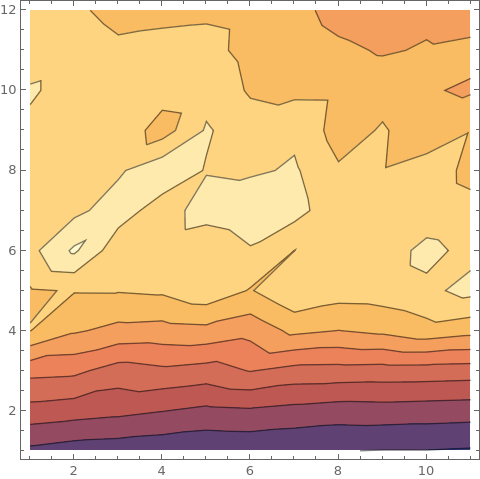

In [16]:
ListContourPlot@Transpose[
    cvList
]

In [14]:
ParallelOuter[f_, args__, opts : OptionsPattern[ParallelMap]] :=
    With[{fullData = Map[Inactive[Identity], Outer[List, args], {Length
         @ {args}}]},
        Activate @ ArrayReshape[ParallelMap[Inactive[Identity] @* Apply[
            f] @* Activate, Flatten @ fullData, opts], Dimensions @ fullData]
    ]

In [7]:
LaunchKernels[7];
LaunchKernels["ssh://cartman?20"];
(* LaunchKernels["ssh://bebe?16"]; *)
LaunchKernels["ssh://stan?20"];
Return[Length @ Kernels[]]

47

In [1]:
2+3

5

In [2]:
Length@Kernels[]

0

In [ ]:
SetDirectory["/import/silo3/wardak/extended-criticality-dnn"]

/import/silo3/wardak/extended-criticality-dnn

In [ ]:
Launch

In [ ]:
ResolventPDF[G1_,G2_]:=Abs[Total[Im@G1]+Total[Im@G2]]/(\[Pi] Length[G2])

SingularValueResolvent[\[Alpha]_?NumericQ, \[Chi]Dist_, \[Chi]Fn_, \[Sigma]_
    ?NumericQ, G1Init_ /; NumericQ[G1Init] || VectorQ[G1Init, NumericQ], 
    G2Init_ /; NumericQ[G2Init] || VectorQ[G2Init, NumericQ], numSteps_?NumericQ,
     numUpdates_:0] :=
    Module[{
        G1 =
            If[NumericQ[G1Init],
                RandomComplex[{-1 - I, 1 + I}, G1Init]
                ,
                G1Init
            ]
        ,
        G2 =
            If[NumericQ[G2Init],
                RandomComplex[{-1 - I, 1 + I}, G2Init]
                ,
                G2Init
            ]
    },
        With[{S = StableDistribution[\[Alpha], 0, 0, (Length @ G1 + Length
             @ G2) ^ (-1 / \[Alpha])], \[Chi]SqSamples = \[Chi]Fn[RandomVariate[\[Chi]Dist,
             Length @ G2]] ^ 2},
            Do[
                With[{g1i = 1 + Mod[step, Length @ G1], g2j = 1 + Mod[
                    step, Length @ G2]},
                    G1[[g1i]] = 1 / (-\[Sigma] - (RandomVariate[S, Length
                         @ G2] ^ 2) . (\[Chi]SqSamples G2));
                    G2[[g2j]] = 1 / (-\[Sigma] - \[Chi]SqSamples[[g2j
                        ]] (RandomVariate[S, Length @ G1] ^ 2) . G1);
                    If[numUpdates > 0 && Mod[step, IntegerPart[numSteps
                         / numUpdates]] === 0,
                        Print[{step, ResolventPDF[G1, G2]}]
                    ]
                ]
                ,
                {step, numSteps}
            ];
            {G1, G2}
        ]
    ]


-Graphics-
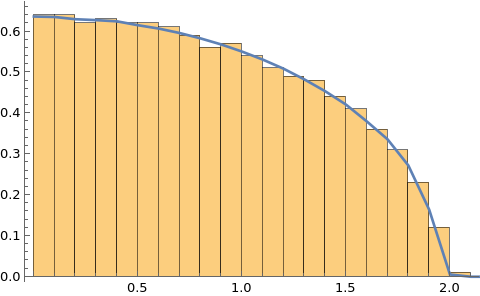

In [ ]:
With[{\[Alpha] = 2, diagSize = 1000},
    Show[Histogram[SingularValueList @ RandomVariate[StableDistribution[
        \[Alpha], 0, 0, (2 diagSize) ^ (-1 / \[Alpha])], {diagSize, diagSize}
        ], {.1}, "PDF"], ListLinePlot @ ParallelTable[{\[Sigma], ResolventPDF
         @@ Nest[SingularValueResolvent[\[Alpha], UniformDistribution[{1, 1}],
         Identity, \[Sigma] + 0.0001 I, ArrayPad[#[[1]], {0, Length @ #[[1]]},
         "Periodic"], ArrayPad[#[[2]], {0, Length @ #[[2]]}, "Periodic"], 5 Length
         @ #[[1]]]&, {RandomComplex[{-1, 1 + I}, 32], RandomComplex[{-1, 1 + 
        I}, 32]}, 5]}, {\[Sigma], 0, 4, .1}]]
]


In [ ]:
QMap[\[Alpha]_?NumericQ,\[Sigma]w_?NumericQ,\[Sigma]b_?NumericQ,\[Phi]_,qInit:(_?NumericQ):3.0,opts:OptionsPattern[{NExpectation,MaxIterations->500,Tolerance->1*^-9}]]:=FixedPointList[q|->\[Sigma]w^\[Alpha] NExpectation[Abs[\[Phi][q^(1/\[Alpha])z]]^\[Alpha],z\[Distributed]StableDistribution[\[Alpha],0,0,2^(-1/\[Alpha])],Sequence@@FilterRules[{opts},Options[NExpectation]]]+\[Sigma]b^\[Alpha],qInit,OptionValue[MaxIterations],SameTest -> (Abs[#1-#2]<OptionValue[Tolerance]&)]

-Graphics-
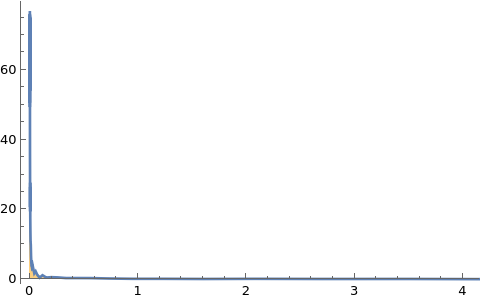

In [ ]:
With[{\[Alpha]=2,\[Sigma]w=3,diagSize=2000},With[{\[Chi]Dist=StableDistribution[\[Alpha],0,0,2^(-1/\[Alpha])],\[Chi]Fn=With[{qStar=Last@Quiet@QMap[\[Alpha],\[Sigma]w,0,Tanh,MaxIterations->10]},\[Eta]|->\[Sigma]w Tanh'[qStar^(1/\[Alpha])\[Eta]]]},Show[
Histogram[
SingularValueList[RandomVariate[StableDistribution[\[Alpha],0,0,(2diagSize)^(-1/\[Alpha])],{diagSize,diagSize}].DiagonalMatrix@\[Chi]Fn@RandomVariate[\[Chi]Dist,diagSize]],
{.01},"PDF"
],
(ListLinePlot[#,PlotRange->All]&)@ParallelTable[{\[Sigma],ResolventPDF@@Nest[
SingularValueResolvent[
\[Alpha],
\[Chi]Dist,
\[Chi]Fn,
\[Sigma]+0.001I,
ArrayPad[#[[1]],{0,Length@#[[1]]},"Periodic"],
ArrayPad[#[[2]],{0,Length@#[[2]]},"Periodic"],
Length@#[[1]]^3
]&,
{RandomComplex[{-1,1+I},4],
RandomComplex[{-1,1+I},4]},
4
]},{\[Sigma],
(* Rest@Subdivide[0,.5,Length@Kernels[]] *)
Exp@Subdivide[-10,Log@10,Length@Kernels[]]
}]]]]

In [ ]:
N@Exp@Subdivide[-3,3,11]

{0.0497871, 0.0859022, 0.148215, 0.255729, 0.441233, 0.7613, 1.31354, 2.26638, 3.91039, 
 
>   6.74695, 11.6411, 20.0855}

{{0. + 0.180172 I, 0.799928, 0.796065, 1.33107, 1.22519, 1.5262, 1.39485, 1.59129, 
 
>    1.27752, 1.32157, 1.14862, 1.15145}, 
 
>   {0.650708, 0.813432, 1.00934, 1.10542, 1.32906, 1.39304, 1.51745, 1.37074, 1.39631, 
 
>    1.58958, 1.32384, 1.26192}, {0.256945, 0.711131, 0.971004, 1.21629, 1.3953, 
 
>    1.38757, 1.54036, 1.51589, 2.07354, 1.27247, 1.49822, 1.2702}, 
 
>   {0.46346, 0.792986, 0.96761, 1.26219, 1.50028, 1.43375, 1.42941, 1.60061, 1.45018, 
 
>    1.33124, 1.7714, 1.55301}, {0.5753, 0.691092, 0.955796, 1.24066, 1.43613, 1.64322, 
 
>    1.8691, 1.62819, 1.34619, 1.30097, 1.4144, 1.53665}, 
 
>   {0.436301, 0.707593, 1.03422, 1.36558, 1.59675, 2.58181, 2.01999, 1.66584, 1.43396, 
 
>    1.46106, 1.31992, 1.46449}, {0.240353, 0.670903, 0.972515, 1.42637, 3.04388, 
 
>    1.60353, 1.78112, 1.41337, 1.6034, 1.35143, 1.39808, 1.53775}, 
 
>   {0.341071, 0.660888, 1.10499, 1.39555, 1.99251, 1.73538, 1.5787, 1.68087, 1.39328, 
 
>    1.49424, 1.42696, 1.80342}, {0.342605, 0.674016, 1.12238, 1.54372, 1.6789, 1.77051, 
 
>    1.48954, 1.36872, 1.52504, 1.52036, 1.35972, 1.20231}, 
 
>   {0.28005, 0.673715, 1.19266, 1.65085, 1.71985, 1.61086, 1.57213, 1.39165, 1.84122, 
 
>    1.28261, 2.05545, 1.55887}, {0.277845, 0.686013, 1.26385, 1.627, 1.6337, 1.66146, 
 
>    1.57394, 1.38459, 1.47796, 1.5073, 1.63398, 1.5887}}
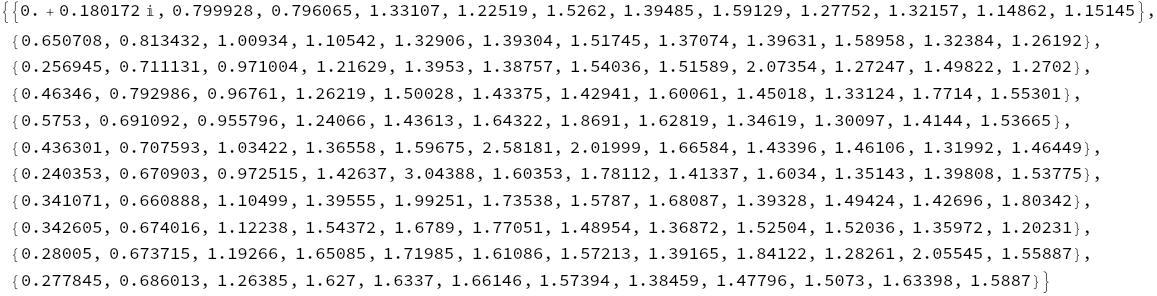

In [ ]:
cvList = ParallelOuter[
{\[Alpha],\[Sigma]w}|->Quiet@With[{\[Chi]Dist=StableDistribution[\[Alpha],0,0,2^(-1/\[Alpha])],\[Chi]Fn=With[{qStar=Last@Quiet@QMap[\[Alpha],\[Sigma]w,0,Tanh,MaxIterations->10]},\[Eta]|->\[Sigma]w Tanh'[qStar^(1/\[Alpha])\[Eta]]],xList=Subdivide[-10,Log@10,11]},With[{pdfs=Table[ResolventPDF@@Nest[
SingularValueResolvent[
\[Alpha],
\[Chi]Dist,
\[Chi]Fn,
Exp[x]+0.001I,
ArrayPad[#[[1]],{0,Length@#[[1]]},"Periodic"],
ArrayPad[#[[2]],{0,Length@#[[2]]},"Periodic"],
Length@#[[1]]^3
]&,
{RandomComplex[{-1,1+I},4],
RandomComplex[{-1,1+I},4]},
4
],{x,xList}]},
Sqrt[Differences[xList].MovingAverage[Exp[xList]pdfs xList^2,2]/(Differences[xList].MovingAverage[Exp[xList]pdfs xList,2])^2-1]
]],
Subdivide[1,2,10],
Subdivide[0.1, 3, 11]
]

-Graphics-
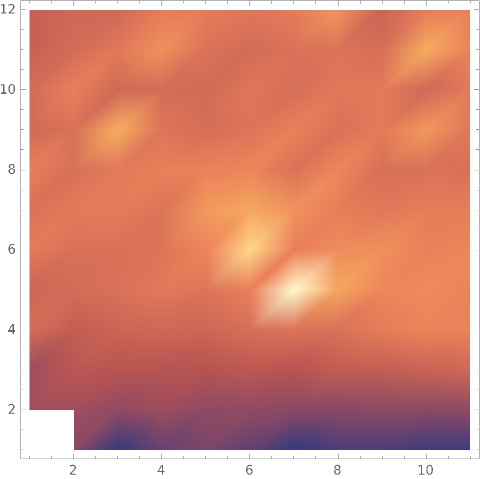

In [ ]:
ListDensityPlot@Transpose@cvList

In [ ]:
ClearAll[logSumExpVec, LogSumExp];

logSumExpVec[v_] := With[{
	m = Max[v]
},
	Plus[
		Log @ Total[Quiet[Exp @ Subtract[v, m], General::munfl]],
		m
	]
];

LogSumExp[array_] := LogSumExp[array, {1}];
LogSumExp[array_, spec_] := ArrayReduce[logSumExpVec, array, spec];

issue with using `ResourceFunction` in jupyter notebooks

In [ ]:
(* Functions for the DNN paper.

Notes:
- We work in log space to avoid numerical instabilities.
- For the inverse CDF we use two forms: one for cdf<0.5 (that works well close to 0), and one for cdf > 0.5 (for close to 1).

*)

prefix = "fig/data";

(* EvaluatePreviousCell = ResourceFunction["EvaluatePreviousCell"]; *)

ParallelOuter[f_, args__, opts : OptionsPattern[ParallelMap]] :=
    With[{fullData = Map[Inactive[Identity], Outer[List, args], {Length
         @ {args}}]},
        Activate @ ArrayReshape[ParallelMap[Inactive[Identity] @* Apply[
            f] @* Activate, Flatten @ fullData, opts], Dimensions @ fullData]
    ]

ParallelOuterWithData[f_, data_, args__, opts : OptionsPattern[ParallelMap
    ]] := (* TODO: rewrite based on ParallelOuter's rewrite *)With[{fullData
     = MapThread[Inactive[Identity] @* Prepend, {Outer[List, args], data},
     2]},
        Activate @ ArrayReshape[ParallelMap[Inactive[Identity] @* Apply[
            f], Activate @ Flatten @ fullData, {Length @ Dimensions @ fullData - 
            1}, opts], Dimensions @ fullData]
    ]

(* LogSumExp = ResourceFunction["LogSumExp"] *)

LogAvgExp[x_] :=
    LogSumExp[x] - Log @ Length @ x

StableDist[\[Alpha]_] :=
    StableDistribution[\[Alpha], 0, 0, 2 ^ (-1 / \[Alpha])]

(* With[{
        c =
            Function[\[Alpha]1,
                Gamma[1 + \[Alpha]1] Sin[\[Pi] \[Alpha]1 / 2] / \[Pi]
                    
            ]
    },
        (c[\[Alpha]] / (4 c[\[Alpha] / 2])) ^ (2 / \[Alpha])
    ] // FullSimplify *)

SDist[\[Alpha]_?NumericQ] :=
    If[\[Alpha] < 2,
        StableDistribution[\[Alpha] / 2, 1, 0, (4 \[Pi]) ^ (-1 / \[Alpha]
            ) (2^\[Alpha] Cos[(\[Pi] \[Alpha]) / 4] Gamma[(1 + \[Alpha]) / 2]) ^ 
            (2 / \[Alpha])]
        ,
        TransformedDistribution[1, {x \[Distributed] NormalDistribution[
            ]}]
    ]

LogQStar[\[Alpha]100_?NumericQ, -\[Infinity] | Indeterminate, -\[Infinity]
     | Indeterminate, \[Phi]_, numSamples_, seed_] :=
    -\[Infinity]

LogQStar[\[Alpha]100_?NumericQ, -\[Infinity] | Indeterminate, log\[Sigma]b_,
     \[Phi]_, numSamples_, seed_] :=
    With[{\[Alpha] = \[Alpha]100 / 100.},
        \[Alpha] log\[Sigma]b
    ]

LogQStar[\[Alpha]100_?NumericQ, log\[Sigma]w_?NumericQ, -\[Infinity] 
    | Indeterminate, \[Phi]_, \[Infinity], seed_] :=
    With[{\[Alpha] = \[Alpha]100 / 100.},
        logq2 /. FindRoot[logq2 - \[Alpha] log\[Sigma]w - Log @ NExpectation[
            Exp[\[Alpha] Log @ Abs[\[Phi][z Exp[logq2 / \[Alpha]]]]], {z \[Distributed]
             StableDist[\[Alpha]]}], {logq2, 1}]
    ]

LogQStar[\[Alpha]100_?NumericQ, log\[Sigma]w_?NumericQ, -\[Infinity] 
    | Indeterminate, \[Phi]_, numSamples_, seed_] :=
    BlockRandom[
        SeedRandom[seed];
    With[{z = RandomVariate[StableDist[\[Alpha]100/100.], numSamples], \[Alpha] = \[Alpha]100
         / 100.},
        logq2 /. FindRoot[logq2 - \[Alpha] log\[Sigma]w - LogAvgExp[\[Alpha]
             * Log @ Abs[\[Phi][z Exp[logq2 / \[Alpha]]]]], {logq2, 1}]
    ]]

LogQStar[\[Alpha]100_?NumericQ, log\[Sigma]w_?NumericQ, log\[Sigma]b_
    ?NumericQ, \[Phi]_, \[Infinity], seed_] :=
    With[{\[Alpha] = \[Alpha]100 / 100.},
        LogSumExp[{logq2, \[Alpha] log\[Sigma]b}] /. FindRoot[logq2 -
             \[Alpha] log\[Sigma]w - Log @ NExpectation[Exp[\[Alpha] Log @ Abs[\[Phi][
            z Exp[LogSumExp[{logq2, \[Alpha] log\[Sigma]b}] / \[Alpha]]]]], {z \[Distributed]
             StableDist[\[Alpha]]}], {logq2, 1}]
    ]

LogQStar[\[Alpha]100_?NumericQ, log\[Sigma]w_?NumericQ, log\[Sigma]b_
    ?NumericQ, \[Phi]_, numSamples_, seed_] :=
    BlockRandom[
        SeedRandom[seed];
    With[{z = RandomVariate[StableDist[\[Alpha]100/100.], numSamples], \[Alpha] = \[Alpha]100
         / 100.},
        LogSumExp[{logq2, \[Alpha] log\[Sigma]b}] /. FindRoot[logq2 -
             \[Alpha] log\[Sigma]w - LogAvgExp[\[Alpha] Log @ Abs[\[Phi][z * Exp[
            LogSumExp[{logq2, \[Alpha] log\[Sigma]b}] / \[Alpha]]]]], {logq2, 1}]
            
    ]]

GetLogQStar[\[Alpha]100_, \[Sigma]w100_, \[Sigma]b100_, \[Phi]_, numSamples_,
     label_:"logqStar"] :=
    With[{paths = FileNames @ StringTemplate["``/``/``/``/``_``_*"][prefix,
         \[Alpha]100, \[Sigma]w100, \[Sigma]b100, label, numSamples]},
        If[Length @ paths > 0,
            Import[First @ paths, "Table"][[1, 1]]
            ,
            With[{log\[Sigma]w = Log[\[Sigma]w100 / 100.], log\[Sigma]b
                 = Log[\[Sigma]b100 / 100.]},
                    LogQStar[\[Alpha]100, log\[Sigma]w, log\[Sigma]b,
                         \[Phi], numSamples]
                ] //
                With[{fname = StringTemplate["``/``/``/``/``_``_``.txt"
                    ][prefix, \[Alpha]100, \[Sigma]w100, \[Sigma]b100, label, numSamples,
                     CreateUUID[]]},
                    Quiet[CreateDirectory @ DirectoryName @ fname, CreateDirectory
                        ::eexist];
                    Export[fname, #, "Table"];
                    #
                ]&
        ]
    ]

LogSech2[x_ ? (VectorQ[#, NumericQ]&)] :=
    2 (Log[2] + x - LogSumExp[{2 x, ConstantArray[0, Length @ x]}]);

LogSech2[x_?NumericQ] :=
    First @ LogSech[{x}]

LogY[\[Alpha]100_?NumericQ, logr_?NumericQ, log\[Chi]_ ? (VectorQ[#, 
    NumericQ]&), seed_] :=
    BlockRandom[
        SeedRandom[seed];
        With[{logS = Log@RandomVariate[SDist[\[Alpha]100/100.], Length@log\[Chi]],
        logSp = Log@RandomVariate[SDist[\[Alpha]100/100.], Length@log\[Chi]],
         \[Alpha] = \[Alpha]100 / 100.},
            logy /.
                FindRoot[
                    \[Alpha] logy - LogAvgExp[(\[Alpha] / 2) (2 log\[Chi]
                         + logS - LogSumExp[{ConstantArray[2 logr - 2 logy, Length @ log\[Chi]
                        ], 2 log\[Chi] + logS + logSp}])], {logy, 0}(*,EvaluationMonitor:>Print[logy]          
                *) ]
        ]
    ]

(*if survivialFlag=True, logs is log the survival fn (i.e.log(1-cdf) instead of log the cdf*)

LogEigCDF[\[Alpha]100_?NumericQ, logr_?NumericQ, log\[Chi]_ ? (VectorQ[
    #, NumericQ]&), seed_, survivalFlag_:False] :=
    BlockRandom[
        SeedRandom[seed];
        With[{logS = Log@RandomVariate[SDist[\[Alpha]100/100.], Length@log\[Chi]],
        logSp = Log@RandomVariate[SDist[\[Alpha]100/100.], Length@log\[Chi]], \[Alpha] = \[Alpha]100 / 100., logy = LogY[\[Alpha]100,
             logr, log\[Chi], seed]},
            If[survivalFlag,
                LogAvgExp[2 log\[Chi] + logS + logSp - LogSumExp[{ConstantArray[
                    2 logr - 2 logy, Length @ log\[Chi]], 2 log\[Chi] + logS + logSp}]]
                ,
                2 logr - 2 logy + LogAvgExp[-LogSumExp[{ConstantArray[
                    2 logr - 2 logy, Length @ log\[Chi]], 2 log\[Chi] + logS + logSp}]]
            ]
        ]
    ]

LogRHat[\[Alpha]100_?NumericQ, logs_?NumericQ, log\[Chi]_ ? (VectorQ[
    #, NumericQ]&), seed_, survivalFlag_:False] :=
    BlockRandom[
        SeedRandom[seed];
        With[{logS = Log@RandomVariate[SDist[\[Alpha]100/100.], Length@log\[Chi]],
        logSp = Log@RandomVariate[SDist[\[Alpha]100/100.], Length@log\[Chi]]},
            logrHat /.
                If[survivalFlag,
                    FindRoot[logs - LogAvgExp[2 log\[Chi] + logS + logSp
                         - LogSumExp[{ConstantArray[2 logrHat, Length @ log\[Chi]], 2 log\[Chi]
                         + logS + logSp}]], {logrHat, 0}]
                    ,
                    FindRoot[logs - 2 logrHat - LogAvgExp[-LogSumExp[
                        {ConstantArray[2 logrHat, Length @ log\[Chi]], 2 log\[Chi] + logS + logSp
                        }]], {logrHat, 0}]
                ]
        ]
    ]

LogInvCDF[\[Alpha]100_?NumericQ, logs_?NumericQ, log\[Chi]_ ? (VectorQ[
    #, NumericQ]&), seed_, survivalFlag_:False] :=
    BlockRandom[
        SeedRandom[seed];
        With[{logS = Log@RandomVariate[SDist[\[Alpha]100/100.], Length@log\[Chi]],
        logSp = Log@RandomVariate[SDist[\[Alpha]100/100.], Length@log\[Chi]], logrHat = LogRHat[\[Alpha]100, logs, log\[Chi], 
            seed, survivalFlag], \[Alpha] = \[Alpha]100 / 100},
            logrHat + (1 / \[Alpha]) LogAvgExp[(\[Alpha] / 2) (2 log\[Chi]
                 + logS - LogSumExp[{ConstantArray[2 logrHat, Length @ log\[Chi]], 2 
                * log\[Chi] + logS + logSp}])]
        ]
    ]

PutJacobianLogInvCDF[\[Alpha]100_, \[Sigma]w100_, \[Sigma]b100_, numSamples_,
     seed_, label_:"loginvCDF"] :=
    Table[
            LogInvCDF[
                \[Alpha]100
                ,
                If[s < 0.5,
                    Log @ s
                    ,
                    Log[1 - s]
                ]
                ,
                Log\[Chi][\[Alpha]100, \[Sigma]w100, \[Sigma]b100, Tanh,
                     numSamples, LogSech2]
                ,
                seed,
                s > 0.5
            ]
            ,
            {s, Most @ Rest @ Subdivide[numSamples + 1]}
        ] // Export[FileNameJoin @ {prefix, ToString @ \[Alpha]100, ToString
             @ \[Sigma]w100, ToString @ \[Sigma]b100, StringTemplate["``_``_``.txt"
            ][label, numSamples, seed]}, #, "Table"]&


Log\[Chi][\[Alpha]100_, \[Sigma]w100_, \[Sigma]b100_, \[Phi]_, numSamples_,
     log\[Phi]p_] :=
    With[{\[Alpha] = \[Alpha]100 / 100, log\[Sigma]w = Log[\[Sigma]w100
         / 100]},
        log\[Sigma]w + log\[Phi]p[Exp[GetLogQStar[\[Alpha]100, \[Sigma]w100,
             \[Sigma]b100, \[Phi], numSamples] / \[Alpha]] GetStableSamples[\[Alpha]100,
             numSamples]]
    ]

(* EmpiricalH[\[Alpha]_, \[Sigma]w_, \[Sigma]b_, \[Phi]_, width_, depth_
    ] :=
    Module[{h = RandomReal[{-1, 1}, width]},
        Do[
            With[{M = \[Sigma]w width ^ (-1 / \[Alpha]) RandomVariate[
                StableDist[\[Alpha]], {width, width}], b = \[Sigma]b RandomVariate[StableDist[
                \[Alpha]], width]},
                h = M . \[Phi][h] + b
            ]
            ,
            depth
        ];
        h
    ] *)

(* Map functions *)

(* one should probably prefer more uniform samples with fewer stable samples to get an accurate average (but more stable samples are better for getting the shape of the CDF) *)

SavePuts[label_, fmt_:"Table", red_:Identity] :=
    GroupBy[FileNames @ FileNameJoin @ {prefix, StringTemplate["*/*/*/``_*.txt"
        ][label]}, (ToExpression @ FileNameSplit[#][[-4 ;; -2]]&) -> (Import[
        #, fmt]&), red] // Export[FileNameJoin @ {prefix, StringTemplate["``.mx"
        ][label]}, #]&

(* PutJacobianEigs[\[Alpha]100_, \[Sigma]w100_, \[Sigma]b100_, n_, prefix_
    :"fig/data"] :=
    With[{logfpStable = GetLogFPStable[\[Alpha]100, \[Sigma]w100, \[Sigma]b100
        ]},
        Export[
            FileNameJoin @ {prefix, StringTemplate["``/``/``/jacEigs_``_``.txt"
                ][\[Alpha]100, \[Sigma]w100, \[Sigma]b100, n, CreateUUID[]]}
            ,
            (\[Sigma]w100 / 100) DiagonalMatrix[Tanh'[Exp[logfpStable
                 / (\[Alpha]100 / 100.)] RandomVariate[StableDist[\[Alpha]100 / 100.],
                 n]]] . RandomVariate[StableDist[\[Alpha]100 / 100.], {n, n}] / n ^ (
                1 / (\[Alpha]100 / 100.)) //
            Eigenvalues //
            ReIm
            ,
            "Table"
        ]
    ] *)

(* PutLogNeuralNorm[\[Alpha]100_, \[Sigma]w100_, \[Sigma]b100_, Infinity,
     prefix_:"fig/data"] :=
    With[{logfpStable = GetLogFPStable[\[Alpha]100, \[Sigma]w100, \[Sigma]b100
        ]},
            Log @ NExpectation[Tanh[Exp[logfpStable / (\[Alpha]100 / 
                100.)] h] ^ 2, {h \[Distributed] StableDist[\[Alpha]100 / 100]}]
        ] // Export[FileNameJoin @ {prefix, StringTemplate["``/``/``/logNeuralNorm_``.txt"
            ][\[Alpha]100, \[Sigma]w100, \[Sigma]b100, CreateUUID[]]}, #, "Table"
            ]&

PutLogNeuralNorm[\[Alpha]100_, \[Sigma]w100_, \[Sigma]b100_, stableSamples_,
     prefix_:"fig/data"] :=
    With[{logfpStable = GetLogFPStable[\[Alpha]100, \[Sigma]w100, \[Sigma]b100
        ]},
            LogAvgExp[2 Log @ Abs @ Tanh[Exp[logfpStable / (\[Alpha]100
                 / 100.)] RandomVariate[StableDist[\[Alpha]100 / 100.], 1000]]]
        ] // Export[FileNameJoin @ {prefix, StringTemplate["``/``/``/logNeuralNorm_``.txt"
            ][\[Alpha]100, \[Sigma]w100, \[Sigma]b100, CreateUUID[]]}, #, "Table"
            ]&

PutEmpiricalLogNeuralNorm[\[Alpha]100_, \[Sigma]w100_, \[Sigma]b100_,
     width_, depth_, prefix_:"fig/data"] :=
    With[{h = EmpiricalH[\[Alpha]100 / 100., \[Sigma]w100 / 100., \[Sigma]b100
         / 100., Tanh, width, depth]},
            LogAvgExp[2 Log @ Abs @ Tanh[h]]
        ] // Export[FileNameJoin @ {prefix, StringTemplate["``/``/``/empiricalLogNeuralNorm_``_``_``.txt"
            ][\[Alpha]100, \[Sigma]w100, \[Sigma]b100, width, depth, CreateUUID[]
            ]}, #, "Table"]&

PutEmpiricalLogSingVals[\[Alpha]100_, \[Sigma]w100_, \[Sigma]b100_, width_,
     depth_, \[Phi]_:Tanh, prefix_:"fig/data", label_:"empiricalLogSingVals"
    ] :=
    With[{\[Alpha] = \[Alpha]100 / 100., \[Sigma]w = \[Sigma]w100 / 100.,
         \[Sigma]b = \[Sigma]b100 / 100.},
            With[{h = EmpiricalH[\[Alpha], \[Sigma]w, \[Sigma]b, \[Phi],
                 width, depth], M = \[Sigma]w width ^ (-1 / \[Alpha]) RandomVariate[StableDist[
                \[Alpha]], {width, width}]},
                Log @ SingularValueList[M . DiagonalMatrix[\[Phi]'[h]
                    ]]
            ]
        ] // Export[FileNameJoin @ {prefix, StringTemplate["``/``/``/``_``_``_``.txt"
            ][\[Alpha]100, \[Sigma]w100, \[Sigma]b100, label, width, depth, CreateUUID[
            ]]}, #, "Table"]&

PutEmpiricalLogAbsEigs[\[Alpha]100_, \[Sigma]w100_, \[Sigma]b100_, width_,
     depth_, \[Phi]_:Tanh, prefix_:"fig/data", label_:"empiricalLogAbsEigs"
    ] :=
    With[{\[Alpha] = \[Alpha]100 / 100., \[Sigma]w = \[Sigma]w100 / 100.,
         \[Sigma]b = \[Sigma]b100 / 100.},
            With[{h = EmpiricalH[\[Alpha], \[Sigma]w, \[Sigma]b, \[Phi],
                 width, depth], M = \[Sigma]w width ^ (-1 / \[Alpha]) RandomVariate[StableDist[
                \[Alpha]], {width, width}]},
                Log @ Abs @ Eigenvalues[M . DiagonalMatrix[\[Phi]'[h]
                    ]]
            ]
        ] // Export[FileNameJoin @ {prefix, StringTemplate["``/``/``/``_``_``_``.txt"
            ][\[Alpha]100, \[Sigma]w100, \[Sigma]b100, label, width, depth, CreateUUID[
            ]]}, #, "Table"]& *)

(*
    Usage: wolframscript -f filename.wl Function1[...] ... FunctionN[...]
    In unix, enclose the functions in double quotes to escape the spaces.
    To pass through strings to wolfram, escape the quotes.
*)

If[Length @ $ScriptCommandLine > 0,
    c = (Print @* EchoTiming @* ToExpression) /@ $ScriptCommandLine[[
        2 ;; ]]
]


In [ ]:
ClearAll@SingularValueResolvent; 
SingularValueResolvent[\[Alpha]_?
   NumericQ, \[Chi]Dist_, \[Chi]Fn_, \[Sigma]_?NumericQ, 
  G1Init_ /; NumericQ[G1Init] || VectorQ[G1Init, NumericQ], 
  G2Init_ /; NumericQ[G2Init] || VectorQ[G2Init, NumericQ], 
  numSteps_?NumericQ, 
  OptionsPattern[{"Regularisation" -> 0.001, 
    "UpdatesPerStep" -> 1}]] := 
 Module[{G1 = 
    If[NumericQ[G1Init], 
     RandomReal[{-1, 1}, G1Init] + I RandomReal[{-1, 1}, G1Init], 
     G1Init], 
   G2 = If[NumericQ[G2Init], 
     RandomReal[{-1, 1}, G2Init] + I RandomReal[{-1, 1}, G2Init], 
     G2Init]}, 
  With[{\[Sigma]Reg = \[Sigma] (1 + OptionValue["Regularisation"] I), 
    k = OptionValue["UpdatesPerStep"], 
    a = N[((Length@G1 + Length@G2)/2)^(-2/\[Alpha])]}, 
   Do[G1[[RandomInteger[{1, Length@G1}, k]]] = 
     1/(-\[Sigma] - 
        a (RandomVariate[
             StableDistribution[\[Alpha], 0, 0, 2^(-1/\[Alpha])], {k, 
              Length@G2}]^2) . (\[Chi]Fn[
              RandomVariate[\[Chi]Dist, Length@G2]]^2 G2)); 
    With[{indices = RandomInteger[{1, Length@G2}, k]}, 
     G2[[indices]] = 
      1/(-\[Sigma] - 
         a \[Chi]Fn[
            RandomVariate[\[Chi]Dist, 
             k]]^2 (RandomVariate[
              StableDistribution[\[Alpha], 0, 0, 2^(-1/\[Alpha])], {k,
                Length@G1}]^2) . G1)], {i, numSteps}]; {G1, G2}]]

ResolventPDF[G1_, G2_] := 
 Abs[Total[Im@G1] + Total[Im@G2]]/(\[Pi] Length[G2])

In [ ]:
QMap[\[Alpha]_?NumericQ, \[Sigma]w_?NumericQ, \[Sigma]b_?
   NumericQ, \[Phi]_, qInit : (_?NumericQ) : 3.0, 
  opts : OptionsPattern[{NExpectation, MaxIterations -> 500, 
     Tolerance -> 1*^-9}]] := 
 FixedPointList[
  q |-> \[Sigma]w^\[Alpha] NExpectation[
      Abs[\[Phi][q^(1/\[Alpha]) z]]^\[Alpha], 
      z \[Distributed] 
       StableDistribution[\[Alpha], 0, 0, 2^(-1/\[Alpha])], 
      Sequence @@ 
       FilterRules[{opts}, 
        Options[NExpectation]]] + \[Sigma]b^\[Alpha], qInit, 
  OptionValue[MaxIterations], 
  SameTest -> (Abs[#1 - #2] < OptionValue[Tolerance] &)]

In [ ]:
EmpiricalIntegrate[fn_, pts_] := 
 Mean[Differences@pts[[;; , 1]] MovingAverage[pts[[;; , 2]], 2] fn[
    MovingAverage[pts[[;; , 1]], 2]]]
    

In [ ]:
SingularValueDensities[\[Alpha]_?
   NumericQ, \[Chi]Dist_, \[Chi]Fn_, \[Sigma]Init_?
   NumericQ, \[Sigma]Lists_?(VectorQ[#, VectorQ[#, NumericQ] &] &), 
  size_?NumericQ] := 
 With[{Ginit = 
    SingularValueResolvent[\[Alpha], \[Chi]Dist, \[Chi]Fn, 
\[Sigma]Init, size, size, 10 size]}, 
  Table[Transpose@{\[Sigma]List, 
        ResolventPDF @@@ 
         Rest@FoldList[
           SingularValueResolvent[\[Alpha], \[Chi]Dist, \[Chi]Fn, #2, 
#1[[1]], #1[[2]], 2 size] &, 
           Ginit, \[Sigma]List]}, {\[Sigma]List, \[Sigma]Lists}]~
     Join~{{{\[Sigma]Init, ResolventPDF @@ Ginit}}} // 
    Flatten[#, 1] & // SortBy[First]]

In [ ]:
(cvList = ParallelOuter[{\[Alpha], \[Sigma]w} |-> 
   With[{\[Chi]Dist = 
       StableDistribution[\[Alpha], 0, 0, 2^(-1/\[Alpha])], \[Chi]Fn =
        With[{qStar = 
          Last@Quiet@
            QMap[\[Alpha], \[Sigma]w, 0, Tanh
            (* ,Method -> "MonteCarlo", 
      MaxIterations -> 50 *)
      ]}, \[Eta] |-> \[Sigma]w Tanh'[
           qStar^(1/\[Alpha]) \[Eta]]]}, 

           With[{pts = 
     Quiet@SingularValueDensities[\[Alpha], \[Chi]Dist, \[Chi]Fn, 
      1, {Rest@Range[1, 4, .01], Most@Rest@Range[1, 0, -.01]}, 500]}, 

   Sqrt[EmpiricalIntegrate[Log[#]^2 &, pts]/
      EmpiricalIntegrate[Log[#] &, pts]^2 - 1]]


     ], 
 Most@Subdivide[1., 2, 10], Rest@Subdivide[0., 3, 20]]
 
 ;) // AbsoluteTiming

{320.796, Null}

-Graphics-
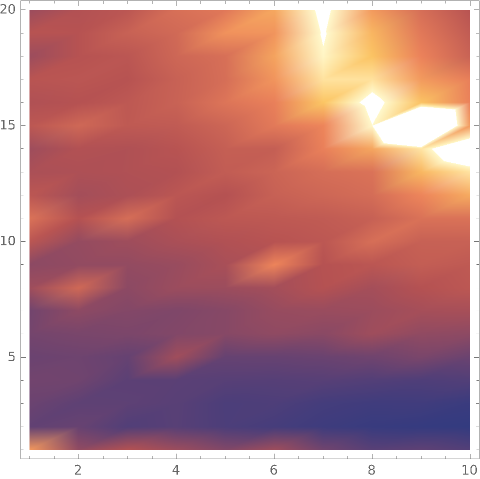

In [ ]:
ListDensityPlot@Transpose@Log@cvList

In [ ]:
With[{\[Alpha] = 1.99, \[Sigma]w = 1.5}, 
 With[{\[Chi]Dist = 
    StableDistribution[\[Alpha], 0, 0, 2^(-1/\[Alpha])], \[Chi]Fn = 
    With[{qStar = 
       Last@Quiet@
         QMap[\[Alpha], \[Sigma]w, 0, Tanh, 
          MaxIterations -> 2]}, \[Eta] |-> \[Sigma]w Tanh'[
        qStar^(1/\[Alpha]) \[Eta]]]}, 
  With[{pts = 
     SingularValueDensities[\[Alpha], \[Chi]Dist, \[Chi]Fn, 
      1, {Rest@Range[1, 4, .1], Most@Rest@Range[1, 0, -.1]}, 5]}, 
   Sqrt[EmpiricalIntegrate[Log[#]^2 &, pts]/
      EmpiricalIntegrate[Log[#] &, pts]^2 - 1]]]]

In [ ]:
ParallelOuter[{\[Alpha], \[Sigma]w} |-> 
  EchoTiming[
   Last@Quiet@
     QMap[\[Alpha], \[Sigma]w, 0, Tanh, Method -> "MonteCarlo", 
      MaxIterations -> 50], {\[Alpha], \[Sigma]w}], 
 Most@Subdivide[1., 2, 10], Rest@Subdivide[0., 3, 10]]

{{0.0000999585, 0.0236192, 0.134782, 0.328801, 0.570124, 0.838693, 1.11913, 1.4109, 
 
                                  -6
>    1.70371, 2.00336}, {2.8639 10  , 0.0141966, 0.115512, 0.318261, 0.586316, 0.889811, 
 
>    1.21674, 1.55783, 1.90732, 2.26344}, 
 
               -9
>   {4.50742 10  , 0.00772795, 0.0975087, 0.309206, 0.603636, 0.945366, 1.31953, 
 
                                            -8
>    1.71825, 2.12962, 2.55383}, {8.03657 10  , 0.00374059, 0.0797696, 0.299948, 
 
>    0.623298, 1.0066, 1.43089, 1.88829, 2.37132, 2.87194}, 
 
               -10
>   {4.79923 10   , 0.000659322, 0.0644353, 0.291923, 0.642751, 1.07073, 1.55157, 
 
                                            -10
>    2.07453, 2.63768, 3.22644}, {2.07027 10   , 0.000173727, 0.0492842, 0.283088, 
 
>    0.665516, 1.13482, 1.67747, 2.27568, 2.921, 3.61662}, 
 
               -10
>   {3.04854 10   , 0.0000311387, 0.0356535, 0.277132, 0.687906, 1.20599, 1.81415, 
 
                                            -10            -9
>    2.49007, 3.23787, 4.04902}, {1.06181 10   , 3.21399 10  , 0.0220791, 0.269283, 
 
>    0.711731, 1.2823, 1.95636, 2.72583, 3.58437, 4.52687}, 
 
               -11            -9
>   {8.85232 10   , 1.01979 10  , 0.00985019, 0.26125, 0.73917, 1.36109, 2.10704, 
 
                                          -11            -10
>    2.97806, 3.965, 5.05876}, {4.54403 10   , 3.91016 10   , 0.0011661, 0.255991, 
 
>    0.76501, 1.44153, 2.27466, 3.25624, 4.37753, 5.65144}}

In [ ]:
ClearAll@JacobianSingValPD; 
JacobianSingValPD[\[Alpha]_?NumericQ, \[Sigma]w_?NumericQ, \[Sigma]b_?
   NumericQ, numQStarSamples_, \[Sigma]_?NumericQ, 
  numSamples_?NumericQ, \[Gamma]_?NumericQ, numSteps_?NumericQ, 
  k_ : 1, reg_ : 0.001] := 
 With[{\[Sigma]Reg = \[Sigma] (1 + reg I), 
   n = numSamples/(\[Gamma] + 1) // IntegerPart, 
   m = numSamples \[Gamma]/(\[Gamma] + 1) // IntegerPart}, 
  With[{a = ((m + n)/2)^(-2/\[Alpha]) // N, \[Chi]Dist = 
     StableDist[\[Alpha]], \[Chi]Fn = 
     With[{logQStar = 
        LogQStar[100 \[Alpha], Log@\[Sigma]w, Log@\[Sigma]b, Tanh, 
         numQStarSamples, 42]}, \[Eta] |-> \[Sigma]w Tanh'[
         Exp[logQStar/\[Alpha]] \[Eta]]]}, 
   Module[{G1 = RandomReal[{-1, 1}, n] + I RandomReal[{-1, 1}, n], 
     G2 = RandomReal[{-1, 1}, m] + I RandomReal[{-1, 1}, m]}, 
    Do[G1[[RandomInteger[{1, n}, k]]] = 
      1/(-\[Sigma] - 
         a (RandomVariate[
              StableDist[\[Alpha]], {k, m}]^2) . (\[Chi]Fn[
               RandomVariate[\[Chi]Dist, m]]^2 G2)); 
     With[{indices = RandomInteger[{1, m}, k]}, 
      G2[[indices]] = 
       1/(-\[Sigma] - 
          a \[Chi]Fn[
             RandomVariate[\[Chi]Dist, 
              k]]^2 (RandomVariate[StableDist[\[Alpha]], {k, n}]^2) . 
            G1)], {i, numSteps}]; 
    Abs@(Total[Im@G1] + Total[Im@G2])/(\[Pi] (m))]]]

LinkObject::linkv: Argument Null in LinkWrite[Null, MessagePacket[General, munfl]] is not a valid LinkObject.

LinkObject::linkv: Argument Null in LinkWrite[Null, MessagePacket[General, munfl]] is not a valid LinkObject.

LinkObject::linkv: Argument Null in LinkWrite[Null, MessagePacket[General, munfl]] is not a valid LinkObject.

General::stop: Further output of LinkObject::linkv will be suppressed during this calculation.

-Graphics-
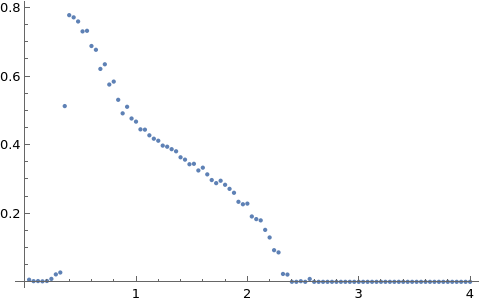

In [ ]:
ParallelTable[{\[Sigma], 
   JacobianSingValPD[1.99, 1.5, 0, 1000, \[Sigma], 1000, 1, 
    10000]}, {\[Sigma], Rest@Subdivide[0, 4, 100]}] // ListPlot

In [ ]:
With[{\[Alpha]List = Most@Subdivide[1, 2, 10], \[Sigma]wList = 
   Rest@Subdivide[0, 3, 10], \[Sigma]List = Rest@Subdivide[0, 10, 100]}, 
 ParallelOuter[
  With[{densities = 
      Table[Quiet@
        JacobianSingValPD[#1, #2, 0, 100, \[Sigma], 100, 1, 
         1000], {\[Sigma], Rest@\[Sigma]List}]}, 
    Sqrt[Mean[
        Differences[\[Sigma]List] densities Log[Rest@\[Sigma]List]^2]/
       Mean[Differences[\[Sigma]List] densities Log[
           Rest@\[Sigma]List]]^2 - 
      1]] &, \[Alpha]List, \[Sigma]wList]] // Transpose // ListDensityPlot